<a href="https://colab.research.google.com/github/JoSungHun/Deeplearning/blob/master/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment

* Due date: **2018/05/07 00:00** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment

* Sentiment classification model using IMDB dataset
  * Compare LSTM and GRU models with **pretrained embedding from Glove**
  * You can download Glove model from the below link.
    * https://drive.google.com/open?id=1NgMR-bnt02gYTr44BVTo2fRePastYypW

> ### Prepare the dataset


In [0]:
!pip install numpy==1.16.1
import numpy as np

In [0]:
from keras.datasets import imdb
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
max_features = 10000
maxlen = 500
max_words=10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

word_index = imdb.get_word_index()


In [0]:
len(x_train)

25000

>###  임베딩 전처리

In [0]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

glove_dir = '/content/gdrive/My Drive'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()  

print('Found %s word vectors.' % len(embeddings_index))

# preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_words:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 400000 word vectors.


> ### Train LSTM model

* Try to find optimal network architecture through controlling the hyperparameters.
  * Candidate 1: Embedding layer + 1-layer LSTM with 16 nodes
  * Candidate 2: Embedding layer + 2-layer LSTM with 16 nodes
  * Candidate 3: Embedding layer + 2-layer LSTM with 32 nodes
  
* To do this, use randomly selected 20% of training dataset as validation dataset.

In [0]:
len(x_train)

25000

In [0]:
from sklearn.model_selection import train_test_split


#20%의 검증데이터를 훈련데이터에서 랜덤하게 선택하기위해 우선적으로 훈련데이터를 랜덤하게 섞어주고 그 후 마지막 20%를 검증데이터로 사용한다.
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Embedding, LSTM


#Candidate 1
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])


lstm_history1 = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_data=(x_valid, y_valid))
model.save_weights('LSTM_candidate1_model.h5')

#Candidate 2
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])

lstm_history2 = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_data=(x_valid, y_valid))
model.save_weights('LSTM_candidate2_model.h5')

#Candidate 3
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])

lstm_history3 = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_data=(x_valid, y_valid))
model.save_weights('LSTM_candidate3_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 110s 6ms/step - loss: 0.6890 - acc: 0.5355 - val_loss: 0.6853 - val_acc: 0.5514
Epoch 2/10
20000/20000 [==============================] - 110s 6ms/step - loss: 0.6711 - acc: 0.5846 - val_loss: 0.6680 - val_acc: 0.5854
Epoch 3/10
20000/20000 [==============================] - 108s 5ms/step - loss: 0.6522 - acc: 0.6140 - val_loss: 0.7078 - val_acc: 0.5592
Epoch 4/10
20000/20000 [==============================] - 109s 5ms/step - loss: 0.6350 - acc: 0.6380 - val_loss: 0.6743 - val_acc: 0.5776
Epoch 5/10
20000/20000 [==============================] - 111s 6ms/step - loss: 0.6193 - acc: 0.6587 - val_loss: 0.6740 - val_acc: 0.6060
Epoch 6/10
20000/20000 [==============================] - 109s 5ms/step - loss: 0.6039 - acc: 0.6742 - val_loss: 0.6853 - val_acc: 0.5970
Epo

* With the selected architecture, compute the final performance on test dataset.
  * 정확도가 비슷하지만 세번째 모델이 제일 높음을 확인할 수 있다.
  

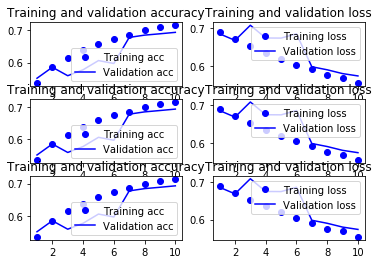

In [0]:
# plotting the results
import matplotlib.pyplot as plt
'''
for i in range(1,4):
  globals()['lstm_acc{}'.format(i)] = globals()['history{}'.format(i).history['acc']]
  globals()['lstm_val_acc{}'.format(i)] = globals()['history{}'.format(i).history['val_acc']]
  globals()['lstm_loss{}'.format(i)] = globals()['history{}'.format(i).history['loss']]
  globals()['lstm_val_loss{}'.format(i)] = globals()['history{}'.format(i).history['val_loss']]

'''
lstm_acc1 = lstm_history1.history['acc']
lstm_val_acc1 = lstm_history1.history['val_acc']
lstm_loss1 = lstm_history1.history['loss']
lstm_val_loss1 = lstm_history1.history['val_loss']

lstm_acc2 = lstm_history1.history['acc']
lstm_val_acc2 = lstm_history1.history['val_acc']
lstm_loss2 = lstm_history1.history['loss']
lstm_val_loss2 = lstm_history1.history['val_loss']

lstm_acc3 = lstm_history1.history['acc']
lstm_val_acc3 = lstm_history1.history['val_acc']
lstm_loss3 = lstm_history1.history['loss']
lstm_val_loss3 = lstm_history1.history['val_loss']

epochs = range(1, len(lstm_acc1) + 1)

plt.subplot(321)
plt.plot(epochs, lstm_acc1, 'bo', label='Training acc')
plt.plot(epochs, lstm_val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(322)
plt.plot(epochs, lstm_loss1, 'bo', label='Training loss')
plt.plot(epochs, lstm_val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(323)
plt.plot(epochs, lstm_acc2, 'bo', label='Training acc')
plt.plot(epochs, lstm_val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(324)
plt.plot(epochs, lstm_loss2, 'bo', label='Training loss')
plt.plot(epochs, lstm_val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.subplot(325)
plt.plot(epochs, lstm_acc3, 'bo', label='Training acc')
plt.plot(epochs, lstm_val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(326)
plt.plot(epochs, lstm_loss3, 'bo', label='Training loss')
plt.plot(epochs, lstm_val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.load_weights('LSTM_candidate3_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 227s 9ms/step


[0.5711777753829956, 0.70244]

70%의 정확도를 보임을 확인할 수 있다.

> ### Train GRU model

* Again, try to find optimal network architecture through controlling the hyperparameters.
  * Candidate 1: Embedding layer + 1-layer GRU with 16 nodes
  * Candidate 2: Embedding layer + 2-layer GRU with 16 nodes
  * Candidate 3: Embedding layer + 2-layer GRU with 32 nodes
  
* To do this, use randomly selected 20% of training dataset as validation dataset.

In [0]:
from keras.layers import GRU

#검증데이터 20%를 랜덤하게 뽑는것은 앞의 LSTM모델을 만들때 랜덤하게 뽑았으므로 여기서는 하지 않는다.

#Candidate 1
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(GRU(16))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])


gru_history1 = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_data=(x_valid, y_valid))
model.save_weights('GRU_candidate1_model.h5')

#Candidate 2
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(GRU(16, return_sequences=True))
model.add(GRU(16))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])

gru_history2 = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_data=(x_valid, y_valid))
model.save_weights('GRU_candidate2_model.h5')

#Candidate 3
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])

gru_history3 = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_data=(x_valid, y_valid))
model.save_weights('GRU_candidate3_model.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.6911 - acc: 0.5344 - val_loss: 0.6850 - val_acc: 0.5524
Epoch 2/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.6735 - acc: 0.5806 - val_loss: 0.6727 - val_acc: 0.5780
Epoch 3/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.6469 - acc: 0.6210 - val_loss: 0.6539 - val_acc: 0.6126
Epoch 4/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.6191 - acc: 0.6546 - val_loss: 0.6675 - val_acc: 0.5984
Epoch 5/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.5972 - acc: 0.6771 - val_loss: 0.6073 - val_acc: 0.6730
Epoch 6/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.5748 - acc: 0.6979 - val_loss: 0.6193 - val_acc: 0.6562
Epoch 7/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.5569 - acc: 0.7153 - val_loss: 0.5517 - val_acc:

* With the selected architecture, compute the final performance on test dataset.
  * 첫번째 모델이 75%로 가장 높은 성능을 보인다.

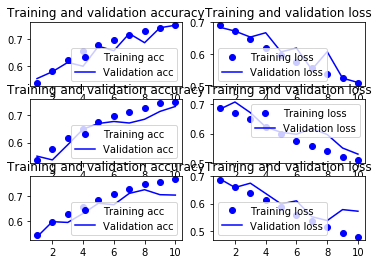

In [0]:
# plotting the results
import matplotlib.pyplot as plt


gru_acc1 = gru_history1.history['acc']
gru_val_acc1 = gru_history1.history['val_acc']
gru_loss1 = gru_history1.history['loss']
gru_val_loss1 = gru_history1.history['val_loss']

gru_acc2 = gru_history2.history['acc']
gru_val_acc2 = gru_history2.history['val_acc']
gru_loss2 = gru_history2.history['loss']
gru_val_loss2 = gru_history2.history['val_loss']

gru_acc3 = gru_history3.history['acc']
gru_val_acc3 = gru_history3.history['val_acc']
gru_loss3 = gru_history3.history['loss']
gru_val_loss3 = gru_history3.history['val_loss']

epochs = range(1, len(gru_acc1) + 1)

plt.subplot(321)
plt.plot(epochs, gru_acc1, 'bo', label='Training acc')
plt.plot(epochs, gru_val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(322)
plt.plot(epochs, gru_loss1, 'bo', label='Training loss')
plt.plot(epochs, gru_val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(323)
plt.plot(epochs, gru_acc2, 'bo', label='Training acc')
plt.plot(epochs, gru_val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(324)
plt.plot(epochs, gru_loss2, 'bo', label='Training loss')
plt.plot(epochs, gru_val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.subplot(325)
plt.plot(epochs, gru_acc3, 'bo', label='Training acc')
plt.plot(epochs, gru_val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(326)
plt.plot(epochs, gru_loss3, 'bo', label='Training loss')
plt.plot(epochs, gru_val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(GRU(16))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])

model.load_weights('GRU_candidate1_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 95s 4ms/step


[0.5103734338855743, 0.74992]

약 75%의 정확도를 보임을 확인할 수 있다.